In [0]:
# Importing the necessary modules and printing their versions.
import pyspark #
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression as LogisticRegressionPySpark
import pyspark.sql.functions as F
import os
import seaborn as sns
import sklearn #
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
import matplotlib #
import matplotlib.pyplot as plt

In [0]:
# data upload.PySpark has its own functionality for creating data frames.Reading the credit card data set in PySpark and
#removing the Class column from the list of columns. This is done because we don’t want the Class column to be included in the feature vector.

data_path = 'dbfs:/FileStore/shared_uploads/01157095@pw.edu.pl/creditcard_pyspark-2.csv'
#df = spark.read.format("csv").load("dbfs:/FileStore/shared_uploads/01157095@pw.edu.pl/creditcard_pyspark-2.csv")
df = spark.read.csv(data_path, header = True, inferSchema = True)
labelColumn = "Class"
columns = df.columns
numericCols = columns
numericCols.remove(labelColumn)
print(numericCols)

['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']

In [0]:
# To show the records in dataset
df.show(2)

+----+----------------+-------------------+----------------+-----------------+------------------+-------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+-----------------+------------------+--------------------+-------------------+------+-----+
Time| V1| V2| V3| V4| V5| V6| V7| V8| V9| V10| V11| V12| V13| V14| V15| V16| V17| V18| V19| V20| V21| V22| V23| V24| V25| V26| V27| V28|Amount|Class|
+----+----------------+-------------------+----------------+-----------------+------------------+-------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+-----------------+------------------+--------------------+-------------------+------+-----+
 0.0|-1.3598071336738|-0.0727811733098497|2.53634673796914| 1.37815522427443|-0.338320769942518| 0.462387777762292| 0.239598554061257|0.0986979012610507| 0.363786969611213|0.0907941719789316|-0.551599533260813|-0.617800855762348|-0.991389847235408|-0.311169353699879| 1.46817697209427|-0.470400525259478| 0.207971241929242|0.0257905801985591| 0.403992960255733| 0.251412098239705|-0.018306777944153| 0.277837575558899|-0.110473910188767|0.0669280749146731|0.128539358273528|-0.189114843888824| 0.133558376740387|-0.0210530534538215|149.62| 0|
 0.0|1.19185711131486| 0.26615071205963|0.16648011335321|0.448154078460911|0.0600176492822243|-0.0823608088155687|-0.0788029833323113|0.0851016549148104|-0.255425128109186|-0.166974414004614| 1.61272666105479| 1.06523531137287| 0.48909501589608|-0.143772296441519|0.635558093258208| 0.463917041022171|-0.114804663102346|-0.183361270123994|-0.145783041325259|-0.0690831352230203|-0.225775248033138|-0.638671952771851| 0.101288021253234|-0.339846475529127|0.167170404418143| 0.125894532368176|-0.00898309914322813| 0.0147241691924927| 2.69| 0|
+----+----------------+-------------------+----------------+-----------------+------------------+-------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+-----------------+------------------+--------------------+-------------------+------+-----+
only showing top 2 rows

In [0]:
# data processing procedure for PySpark is slightly different than in pandas. To train the model, we must pass in a vector called features.
# Here we define input to the assembler,so that it knows what columns to transfer into feature vectors.
stages = []
assemblerInputs = numericCols
assembler = VectorAssembler(inputCols=assemblerInputs,outputCol="features")
stages += [assembler]

dfFeatures = df.select(F.col(labelColumn).alias('label'),*numericCols )
# Here we split the data as ps_genuine and ps_fradulent as done in scikit-learn.Since we don't perform validation test here,so we split the data in 80-20 ratio for testing #and training data.
ps_genuine = dfFeatures.filter("Class == 0").sample(withReplacement=False, fraction=0.5, seed=2020)
ps_fradulent = dfFeatures.filter("Class == 1")

ps_genuine_train, ps_genuine_test = ps_genuine.randomSplit([0.8, 0.2],seed = 2020)
ps_fradulent_train, ps_fradulent_test = ps_fradulent.randomSplit([0.8, 0.2],seed = 2020)

In [0]:
# Split data set in to training and test is similar as in scikit-learn but with PySpark functionality
train = ps_genuine_train.union(ps_fradulent_train)
test = ps_genuine_test.union(ps_fradulent_test)

In [0]:
# Using pipeline and created feature vector from data frame. This will be used to train logistic regression model.
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(dfFeatures)
train = pipelineModel.transform(train)
test = pipelineModel.transform(test)
selectedCols = ['label', 'features'] + numericCols
train = train.select(selectedCols)
test = test.select(selectedCols)

print("Training Dataset Count: ", train.count())
print("Test Dataset Count: ", test.count())

Training Dataset Count: 113995
Test Dataset Count: 28569

In [0]:
# Model Training . Defining and training logistic regression model.
lr = LogisticRegressionPySpark(featuresCol = 'features',labelCol = 'label', maxIter=10)

lrModel = lr.fit(train)

trainingSummary = lrModel.summary
# Finding the AUC score from the built-in function of the model.
pyspark_auc_score = trainingSummary.areaUnderROC

In [0]:
# Model Evaluation: We run the below code to evaluate our model,once training is over.
# prediction will calculate the prediction and lable them
# evaluation will evaluate our test model
# Accuracy will compare the results from evaluation and find the accuracy
predictions = lrModel.transform(test)
y_true = predictions.select(['label']).collect()
y_pred = predictions.select(['prediction']).collect()
evaluations = lrModel.evaluate(test)
accuracy = evaluations.accuracy
# Print results of AUC score and accuracy score.
print(f"AUC Score: {roc_auc_score(y_pred, y_true):.3%}")
print(f"PySpark AUC Score: {pyspark_auc_score:.3%}")
print(f"Accuracy Score: {accuracy:.3%}")

AUC Score: 95.169%
PySpark AUC Score: 97.857%
Accuracy Score: 99.902%

Out[10]:

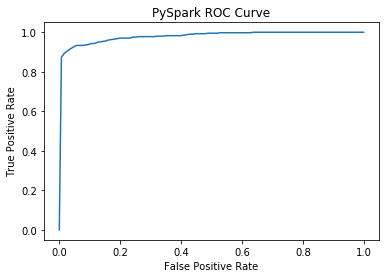

[<matplotlib.lines.Line2D at 0x7f41cc08b850>]

In [0]:
# As AUC score is very high,lets check ROC curve . A perfect ROC curve would have the true positive rate starting at 1.0, where it continues right to a false positive rate
#value of 1.0. Our curve is quite close to that, hence why its area (AUC) is said to be around 0.97997 by PySpark, keeping in mind a perfect AUC score is 1.00
pyspark_roc = trainingSummary.roc.toPandas()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('PySpark ROC Curve')
plt.plot(pyspark_roc['FPR'],pyspark_roc['TPR'])

Out[11]:

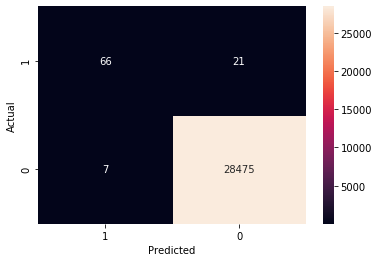

Text(0.5, 15.0, 'Predicted')

In [0]:
# Confusioin Matrix.The accuracy of correctly labeled points for the normal data is very high and is decent for the fradulent data
conf_matrix = confusion_matrix(y_true, y_pred)
ax = sns.heatmap(conf_matrix, annot=True,fmt='g')
ax.invert_xaxis()
ax.invert_yaxis()
plt.ylabel('Actual')
plt.xlabel('Predicted')